In [27]:
import pandas as pd


data = pd.read_excel("GAIA IA v.1.2.xlsx")
data = data.drop(data.columns[0], axis=1)
mapping = {0: 'Al2O3', 1: 'Fe2O3', 2: '>63mm', 3: '>45mm', 4:'CS-C', 5: 'RMS', 6: 'A.A.', 7: 'Carbono', 8: 'L', 9: 'a', 10: '%'}
for i in range(11):
    data.rename(columns={data.columns[i]: mapping[i]+'.0'}, inplace=True)

In [28]:
actual_zeros = set()
total_zeros = 0
for i in range(len(data)):
    for j in range(len(mapping)-1):
        for k in range(7):
            if data.iloc[i, j+11*k] == 0 and data.iloc[i, 10+ 11*k] != 0:
                actual_zeros.add((i, j+11*k))

for col in data.columns:
    if col not in actual_zeros:
        data[col] = data[col].replace(0, 1e-10)
for i, j in actual_zeros:
    data.iloc[i, j] = 0



In [29]:
y = data[['Al2O3.7', 'Fe2O3.7', 'CS-C.7', 'Carbono.7']]
X = data.drop(columns=['Al2O3.7', 'Fe2O3.7', 'CS-C.7', 'Carbono.7'])
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import MeanAbsoluteError, MeanSquaredError, R2Score
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 4), dtype=torch.float32) #1 ->4
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 4), dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(77, 64),
            nn.ReLU(),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Linear(32, 4)  
        )

    def forward(self, x):
        return self.net(x)

model = RegressionModel()



criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

loss_values = []

epochs = 200
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")


model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    mse = criterion(predictions, y_test_tensor)
    mae = torch.mean(torch.abs(predictions - y_test_tensor))
    r2 = 1 - (torch.sum((predictions - y_test_tensor) ** 2) / torch.sum((y_test_tensor - torch.mean(y_test_tensor)) ** 2))
    print(f"\nTest MSE: {mse.item():.4f}, MAE: {mae.item():.4f}", f"R2: {r2.item():.4f}")




Epoch 1/200, Loss: 191.6438
Epoch 2/200, Loss: 184.4470
Epoch 3/200, Loss: 170.9783
Epoch 4/200, Loss: 146.5834
Epoch 5/200, Loss: 109.5424
Epoch 6/200, Loss: 64.5228
Epoch 7/200, Loss: 25.9946
Epoch 8/200, Loss: 11.7938
Epoch 9/200, Loss: 11.0842
Epoch 10/200, Loss: 6.8661
Epoch 11/200, Loss: 4.6366
Epoch 12/200, Loss: 3.9432
Epoch 13/200, Loss: 3.3711
Epoch 14/200, Loss: 2.9251
Epoch 15/200, Loss: 2.4728
Epoch 16/200, Loss: 2.2087
Epoch 17/200, Loss: 2.0415
Epoch 18/200, Loss: 1.8326
Epoch 19/200, Loss: 1.8054
Epoch 20/200, Loss: 1.6782
Epoch 21/200, Loss: 1.4479
Epoch 22/200, Loss: 1.3212
Epoch 23/200, Loss: 1.2506
Epoch 24/200, Loss: 1.1558
Epoch 25/200, Loss: 1.0463
Epoch 26/200, Loss: 0.9877
Epoch 27/200, Loss: 0.9118
Epoch 28/200, Loss: 0.8551
Epoch 29/200, Loss: 0.8002
Epoch 30/200, Loss: 0.7521
Epoch 31/200, Loss: 0.7261
Epoch 32/200, Loss: 0.6754
Epoch 33/200, Loss: 0.6601
Epoch 34/200, Loss: 0.5941
Epoch 35/200, Loss: 0.5372
Epoch 36/200, Loss: 0.5085
Epoch 37/200, Loss: 0.4

In [31]:

def plot_loss():
    plt.figure(figsize=(10, 5))
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()

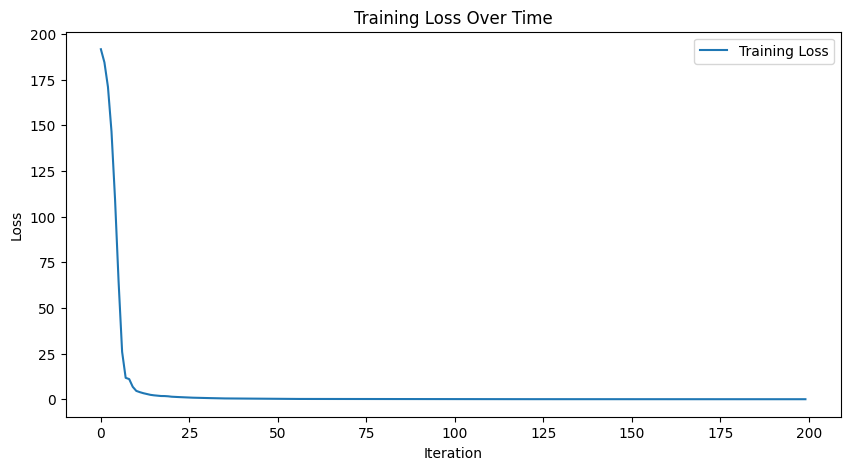

In [32]:
plot_loss()

In [33]:
def plot_compare():
    target_names = ['Al2O3', 'Fe2O3', 'CS-C', 'Carbono']

    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    for i, ax in enumerate(axs.ravel()):
        actual = y_test_tensor[:, i].numpy()
        pred = predictions[:, i].numpy()
        ax.plot(actual, label='Actual', color='blue')
        ax.plot(pred, label='Predicted', linestyle='--', color='orange')
        ax.set_title(f'{target_names[i]}: Actual vs Predicted')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel(target_names[i])
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

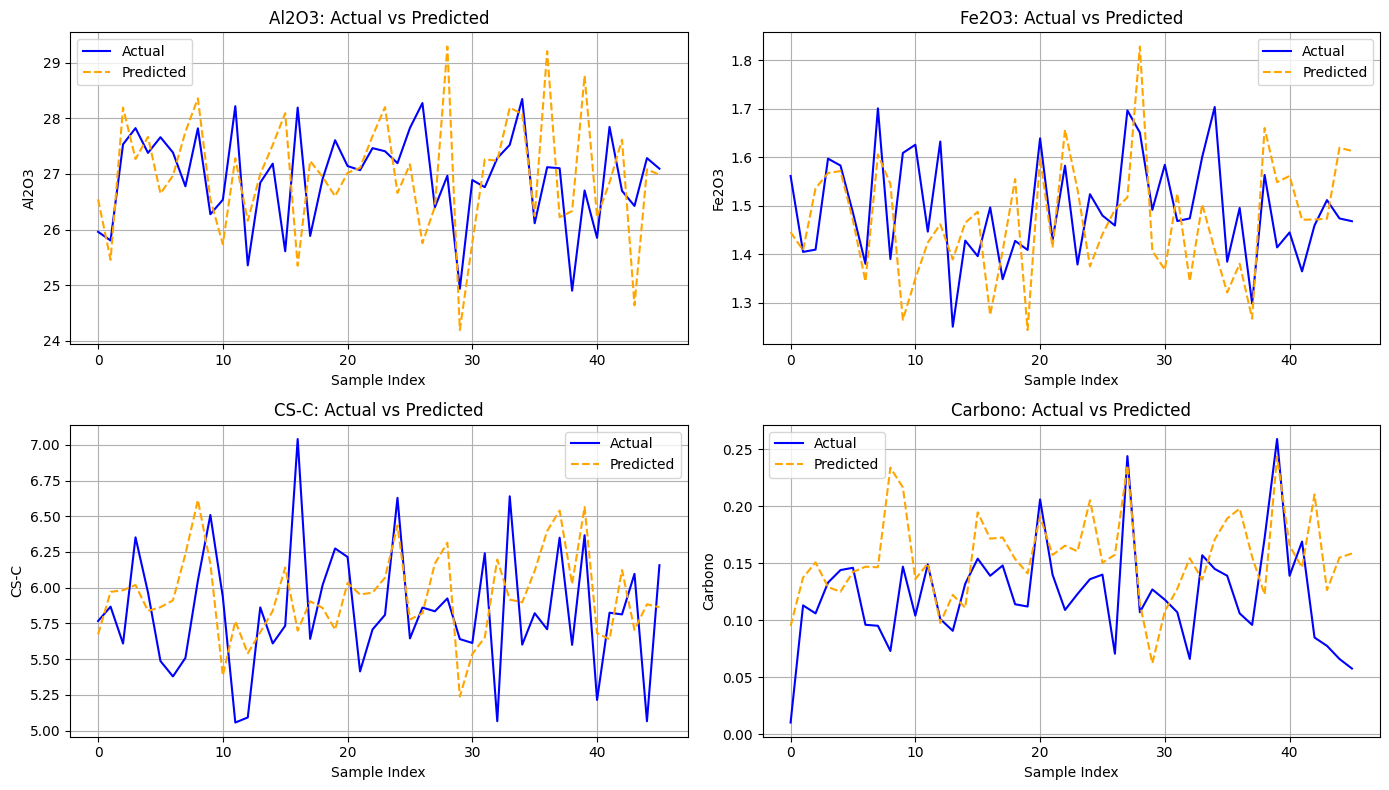

In [34]:
plot_compare()

In [35]:
def evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=5):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        mse = nn.MSELoss()(predictions, y_test_tensor).item()
        mae = torch.mean(torch.abs(predictions - y_test_tensor)).item()
        

    y_true = y_test_tensor.numpy().flatten()
    y_pred = predictions.numpy().flatten()

    results_df = pd.DataFrame({
        'Actual': y_true,
        'Predicted': y_pred,
        'Error': y_pred - y_true
    })

    print(f"Evaluation Results:\n - MSE: {mse:.4f}\n - MAE: {mae:.4f} \n - R2: {r2.item():.4f}")
    print("\nExample predictions:")
    print(results_df.head(n))

    return results_df

In [36]:
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10)

Evaluation Results:
 - MSE: 0.3633
 - MAE: 0.3430 
 - R2: 0.9969

Example predictions:
      Actual  Predicted     Error
0  25.960688  26.544270  0.583582
1   1.561302   1.445244 -0.116058
2   5.767001   5.674110 -0.092891
3   0.010200   0.094998  0.084798
4  25.805275  25.458525 -0.346750
5   1.404642   1.408128  0.003486
6   5.867491   5.970913  0.103422
7   0.113000   0.137382  0.024382
8  27.533176  28.193048  0.659872
9   1.409339   1.535627  0.126288


## NN for the first 3 raw materials


In [42]:
y = data[['Al2O3.7', 'Fe2O3.7', 'CS-C.7', 'Carbono.7']]
X = data.iloc[:, :33]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 4), dtype=torch.float32) #1 ->4
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 4), dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(33, 64),
            nn.ReLU(),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Linear(32, 4)  
        )

    def forward(self, x):
        return self.net(x)

model = RegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

loss_values = []

epochs = 200
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    mse = criterion(predictions, y_test_tensor)
    mae = torch.mean(torch.abs(predictions - y_test_tensor))
    r2 = 1 - (torch.sum((predictions - y_test_tensor) ** 2) / torch.sum((y_test_tensor - torch.mean(y_test_tensor)) ** 2))
    print(f"\nTest MSE: {mse.item():.4f}, MAE: {mae.item():.4f}", f"R2: {r2.item():.4f}")
    


Epoch 1/200, Loss: 188.8341
Epoch 2/200, Loss: 183.1765
Epoch 3/200, Loss: 176.4873
Epoch 4/200, Loss: 168.3712
Epoch 5/200, Loss: 156.6099
Epoch 6/200, Loss: 141.6073
Epoch 7/200, Loss: 121.9556
Epoch 8/200, Loss: 98.9337
Epoch 9/200, Loss: 73.9853
Epoch 10/200, Loss: 50.1935
Epoch 11/200, Loss: 31.0191
Epoch 12/200, Loss: 17.6789
Epoch 13/200, Loss: 9.5950
Epoch 14/200, Loss: 7.1175
Epoch 15/200, Loss: 6.6055
Epoch 16/200, Loss: 5.5422
Epoch 17/200, Loss: 4.6231
Epoch 18/200, Loss: 3.8770
Epoch 19/200, Loss: 3.4146
Epoch 20/200, Loss: 3.0886
Epoch 21/200, Loss: 2.7754
Epoch 22/200, Loss: 2.5621
Epoch 23/200, Loss: 2.2869
Epoch 24/200, Loss: 2.1290
Epoch 25/200, Loss: 1.9470
Epoch 26/200, Loss: 1.7876
Epoch 27/200, Loss: 1.6796
Epoch 28/200, Loss: 1.5673
Epoch 29/200, Loss: 1.4864
Epoch 30/200, Loss: 1.3615
Epoch 31/200, Loss: 1.2854
Epoch 32/200, Loss: 1.2359
Epoch 33/200, Loss: 1.1835
Epoch 34/200, Loss: 1.1014
Epoch 35/200, Loss: 1.0679
Epoch 36/200, Loss: 1.0212
Epoch 37/200, Loss

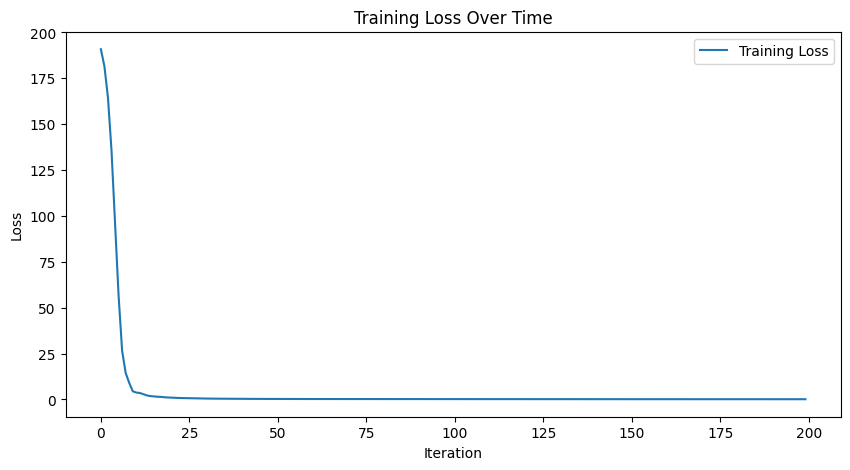

In [38]:
plot_loss()

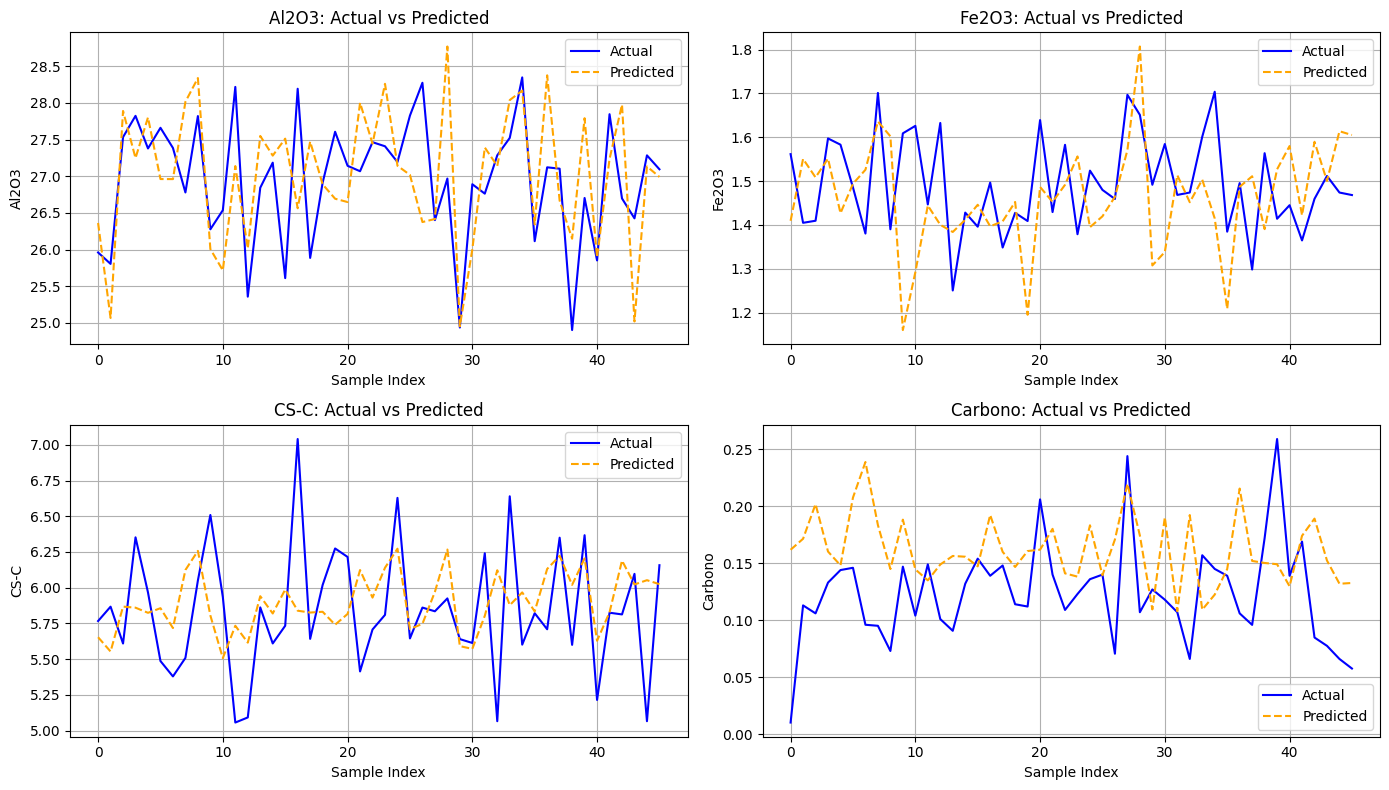

In [39]:
plot_compare()

In [40]:
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10)

Evaluation Results:
 - MSE: 0.2513
 - MAE: 0.3076 
 - R2: 0.9978

Example predictions:
      Actual  Predicted     Error
0  25.960688  26.362471  0.401783
1   1.561302   1.409236 -0.152066
2   5.767001   5.653817 -0.113184
3   0.010200   0.161808  0.151608
4  25.805275  25.068027 -0.737247
5   1.404642   1.550477  0.145835
6   5.867491   5.553545 -0.313945
7   0.113000   0.171448  0.058448
8  27.533176  27.889355  0.356178
9   1.409339   1.508244  0.098904
